# Ratio and number of samples having a slight chance of or being susceptible to misclassification by different primer sets

### Import modules 

In [1]:
import psycopg2 # PostgreSQL database adapter

import pandas as pd # data analysis and manipulation tool
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import time
from datetime import datetime, date


from  matplotlib import pyplot # visualization tool
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as tkr

import sys
sys.path.append('/v/anikomentes/p3_packages/labellines/')
import labellines as LL

import seaborn as sns #  visualization tool
sns.set(style='whitegrid')
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
sns.set_context("notebook", rc={"font.size":16,"axes.titlesize":12,"axes.labelsize":12})

#### High risk mutations
We designated all insertions and deletions, along with mismatches that occur in the first 5 positions of the 3' end of the forward and backward primer TRs or the middle of the probe TR (5 base pairs inward from the two ends) as „high risk” mutations and assigned „moderate risk” to the rest of the variants.

- Load the data

Samples and mutations

In [2]:
df_samples = pd.read_csv('Base_table_samples.csv')

print(df_samples.shape)

df_samples.head()

(3289, 4)


,ref,pos,alt,ena_run
0,A,808,C,ERR6722191
1,A,808,G,"SRR15748011, SRR16144601, SRR15831161, SRR1629..."
2,A,808,T,"SRR15395150, SRR15462988, SRR15544988, SRR1543..."
3,A,810,C,"SRR16921386, SRR15546162"
4,A,810,G,"SRR17129598, SRR17420000, ERR7322569, ERR53142..."


Primers information and mutations

In [3]:
df_primers = pd.read_csv('Base_table_primers.csv', index_col=0)
df_primers.reset_index(inplace=True)

print(df_primers.shape)

df_primers.head()

(4373, 7)


,ref,pos,alt,risk_pos,primer_set,primer,type
0,G,804,A,0,Davi-set,Davi-ORF1a-1,F
1,G,805,A,0,Davi-set,Davi-ORF1a-1,F
2,G,805,T,0,Davi-set,Davi-ORF1a-1,F
3,G,806,A,0,Davi-set,Davi-ORF1a-1,F
4,G,806,T,0,Davi-set,Davi-ORF1a-1,F


Samples and collection date

In [4]:
df_dates = pd.read_csv('dates220808.csv')
df_dates = df_dates.assign(ena_run=df_dates['ena_run'].str.split(', ')).explode('ena_run')
print(df_dates.shape)

df_dates.head()

(639779, 2)


,collection_date,ena_run
0,2021-01-01,ERR5088291
0,2021-01-01,ERR5088615
0,2021-01-01,ERR5089334
0,2021-01-01,ERR5089662
0,2021-01-01,ERR5090416


Samples and variant_id (lineage)

In [5]:
df_variants = pd.read_csv('variants220808.csv')
df_variants = df_variants.assign(ena_run=df_variants['ena_run'].str.split(', ')).explode('ena_run')
print(df_variants.shape)

df_variants.head()

(639779, 2)


,variant_id,ena_run
0,Alpha,ERR5088291
0,Alpha,ERR5088615
0,Alpha,ERR5089334
0,Alpha,ERR5089662
0,Alpha,ERR5090416


Merge dataframes

In [6]:
df_all = pd.merge(df_samples,df_primers)
df_all = df_all.assign(ena_run=df_all['ena_run'].str.split(', ')).explode('ena_run')
print(df_all.shape)

(3781378, 8)


In [7]:
df_all = pd.merge(df_all, df_variants)
print(df_all.shape)
df_all.head()

(3781378, 9)


,ref,pos,alt,ena_run,risk_pos,primer_set,primer,type,variant_id
0,A,808,C,ERR6722191,0,Davi-set,Davi-ORF1a-1,F,Delta
1,C,21618,G,ERR6722191,0,Sarkar-set,Sarkar-S,F,Delta
2,G,15451,A,ERR6722191,0,Tombuloglu-set,Tombuloglu-RdRp,F,Delta
3,G,15451,A,ERR6722191,1,Niu-set,Niu-RdRp,F,Delta
4,G,15451,A,ERR6722191,0,Won-set,Won-RdRp-1,F,Delta


In [8]:
df_all = pd.merge(df_all, df_dates)
print(df_all.shape)
df_all.head()

(3781378, 10)


,ref,pos,alt,ena_run,risk_pos,primer_set,primer,type,variant_id,collection_date
0,A,808,C,ERR6722191,0,Davi-set,Davi-ORF1a-1,F,Delta,2021-06-08
1,C,21618,G,ERR6722191,0,Sarkar-set,Sarkar-S,F,Delta,2021-06-08
2,G,15451,A,ERR6722191,0,Tombuloglu-set,Tombuloglu-RdRp,F,Delta,2021-06-08
3,G,15451,A,ERR6722191,1,Niu-set,Niu-RdRp,F,Delta,2021-06-08
4,G,15451,A,ERR6722191,0,Won-set,Won-RdRp-1,F,Delta,2021-06-08


## EXAMPLE

Use 'pos', 'ena_run', 'primer_set', 'primer', 'type', 'risk_pos' columns for the example

In [9]:
df_all = df_all[['pos', 'ena_run', 'primer_set', 'primer', 'type', 'risk_pos']].drop_duplicates()

print(df_all.shape)

df_all.head()

(3781378, 6)


,pos,ena_run,primer_set,primer,type,risk_pos
0,808,ERR6722191,Davi-set,Davi-ORF1a-1,F,0
1,21618,ERR6722191,Sarkar-set,Sarkar-S,F,0
2,15451,ERR6722191,Tombuloglu-set,Tombuloglu-RdRp,F,0
3,15451,ERR6722191,Niu-set,Niu-RdRp,F,1
4,15451,ERR6722191,Won-set,Won-RdRp-1,F,0


#### Damaged TRs in samples
A TR is defined to be damaged if at least a single high risk mutation or a minimum of 3 mutations of any kind are present in it.

- Filter samples that contain at least one damaged TR in a primer system

In [10]:
df1 = df_all[['ena_run', 'primer_set', 'primer', 'type', 'risk_pos']]

df1 = df1.assign(result = np.where(df1['risk_pos']=='0' ,df1['risk_pos'].count(),df1['risk_pos'].sum()))\
   .groupby(['ena_run', 'primer_set', 'primer', 'type', 'risk_pos']).agg({'result':'count'})

df1.reset_index(inplace=True)

df1.loc[(df1['risk_pos'] > 0) | (df1['result'] > 2), 'risk_sample'] = 1
df1.loc[(df1['risk_pos'] == 0) & (df1['result'] < 3), 'risk_sample'] = 0
df1 = df1[['ena_run', 'primer_set', 'primer', 'type', 'risk_sample']].groupby(['ena_run', 'primer_set', 'primer', 'type']).max()

df2 = df1[df1['risk_sample']==1].groupby(['ena_run', 'primer_set', 'primer']).count()
df2.reset_index(inplace=True)
df3 = df2[['ena_run', 'primer_set', 'primer']]
df = df3.copy()
print(df3.shape)

df3.head()

(1137784, 3)


,ena_run,primer_set,primer
0,ERR5088076,Niu-set,Niu-N
1,ERR5088076,Young-set,Young-S
2,ERR5088110,Niu-set,Niu-N
3,ERR5088110,Young-set,Young-S
4,ERR5088155,Niu-set,Niu-N


- How many primer systems of the given set have damaged TRs in a sample?

In [11]:
df3 = df3.groupby(['ena_run', 'primer_set']).count()

df3.reset_index(inplace=True)

print(df3.shape)

df3.head()

(1129048, 3)


,ena_run,primer_set,primer
0,ERR5088076,Niu-set,1
1,ERR5088076,Young-set,1
2,ERR5088110,Niu-set,1
3,ERR5088110,Young-set,1
4,ERR5088155,Niu-set,1


- grouped by primer-sets and the number of primer systems having any damaged TRs

In [12]:
df3 = df3.groupby(['primer_set', 'primer']).count()
df3.reset_index(inplace=True)
df3.columns = ['primer_set', 'systems_number', 'count']

print(df3.shape)

df3.head()

(32, 3)


,primer_set,systems_number,count
0,Chan-set,1,14859
1,Chan-set,2,72
2,Chan-set,3,1
3,Chu-set,1,3364
4,Chu-set,2,11


GET PCR PRIMER TABLES AND NUMBER OF PRIMER SYSTEMS

In [13]:
pp = pd.read_csv('../manuscript_tables/Fig2_all_per_system_pcr.csv')

pp = pp[['primer_set', 'primer_name']].drop_duplicates().groupby('primer_set').count()
pp.reset_index(inplace=True)
pp.columns = ['primer_set', 'no_of_tg']

print(pp.shape)

pp.head()

(16, 2)


,primer_set,no_of_tg
0,Chan-set,3
1,Chu-set,2
2,Corman-set,3
3,DMSC-set,1
4,Davi-set,9


Get all samples values and sort results

In [14]:
tt2 = df[['primer_set', 'primer', 'ena_run']].drop_duplicates().groupby(['primer_set', 'primer']).count()
tt2.reset_index(inplace=True)
tt2.columns = ['primer_set', 'primer_name', 'count']

tt = tt2.groupby(['primer_name']).sum().sort_values(by=['count'], ascending=False)
tt.reset_index(inplace=True)

tt1 = tt2.groupby(['primer_set']).sum().sort_values(by=['count'], ascending=False)
tt1.reset_index(inplace=True)

sorter1 = list(tt1['primer_set'])
sorterIndex1 = dict(zip(sorter1, range(len(sorter1))))
tt2['Rank1'] = tt2['primer_set'].map(sorterIndex1)
sorter2 = list(tt['primer_name'])
sorterIndex2 = dict(zip(sorter2, range(len(sorter2))))
tt2['Rank2'] = tt2['primer_name'].map(sorterIndex2)

tt2.sort_values(['Rank1', 'Rank2'],
        ascending = [True, True], inplace = True)
tt2.drop('Rank1', 1, inplace = True)
tt2.drop('Rank2', 1, inplace = True)

#print(tt2.shape)

#######

tg = df3.merge(pp, how='outer')

tg['sample%'] = tg['count'] / 665325

tg = tg[['primer_set', 'systems_number', 'count','sample%', 'no_of_tg']]

get_index = -1

for es in pd.unique(tg.primer_set):
    temp_df = tg[tg.primer_set == es]
    full_list = [*range(1,int(pp[pp.primer_set == es].no_of_tg)+1)]
    temp_list = temp_df.systems_number.tolist()
    miss_list= (list(set(full_list) - set(temp_list)))
    for element in miss_list:
        tg.loc[get_index] = [es,element,0,0,int(pp[pp.primer_set == es].no_of_tg)]
        get_index = get_index-0.1
    
sorter = list(tt2['primer_set'])
sorterIndex = dict(zip(sorter, range(len(sorter))))
tg['Rank'] = tg['primer_set'].map(sorterIndex)
tg.sort_values(['Rank', 'systems_number'],
        ascending = [True, True], inplace = True)
tg.drop('Rank', 1, inplace = True)

tg['system_case'] = tg['primer_set'] +"-"+ tg['systems_number'].map(str)


#######

test = tg.copy()
test['treshold'] = (test['no_of_tg']*0.5)

test['susceptible'] = test[test['systems_number'] >= test['treshold']]['count'].groupby(test['primer_set']).transform('sum')
test['slight chance'] = test[test['systems_number'] < test['treshold']]['count'].groupby(test['primer_set']).transform('sum')
test = test.fillna(0)
test1 = test[['primer_set', 'susceptible', 'slight chance']].drop_duplicates()
test1 = test1[['primer_set', 'susceptible', 'slight chance']].groupby(by=['primer_set']).sum()
test1.reset_index(inplace=True)

df5 = test1.melt(id_vars=["primer_set"], 
    var_name="misclassification", 
    value_name="count")
df5['sample%'] = df5['count'] / 665325

sorter = list(tt2['primer_set'])
sorterIndex = dict(zip(sorter, range(len(sorter))))
df5['Rank'] = df5['primer_set'].map(sorterIndex)
df5.sort_values(['Rank'],
        ascending = [True], inplace = True)
df5.drop('Rank', 1, inplace = True)

df5 = df5.merge(pp)


Plot

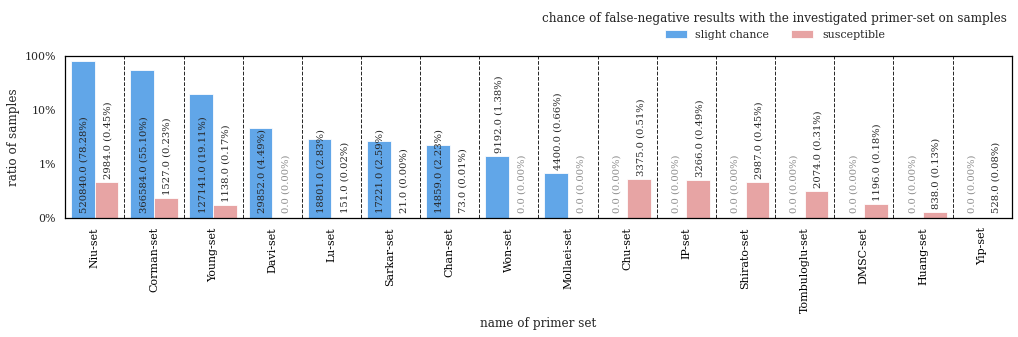

In [15]:
colors=('dodgerblue', 'lightcoral')
genz = ['slight chance', 'susceptible']
palette=dict(zip(genz, colors))

g2 = sns.catplot(
    data=df5, kind="bar",
    x="primer_set", y="sample%", hue="misclassification",
    ci="sd", palette=palette, alpha=.8, height=3, aspect=14/3, edgecolor="white", dodge = True, legend=False
)

g2.despine(left=True)
g2.set_axis_labels("name of primer set", "ratio of samples")

g2.set_xticklabels(rotation=90, color='black')

plt.ylim([10**-3,10**0])
plt.yscale('log')

for i,j in enumerate(df5[['primer_set', 'no_of_tg']].drop_duplicates()['no_of_tg']):
    df4 = df5[df5['misclassification'] == 'slight chance']
    string = str(list(df4['count'])[i])+" ("+str(format(round(list(df4['sample%'])[i]*100, 3), '.2f'))+"%)"
    if list(df4['count'])[i] < 1:
        plt.text(i-0.25, 0.00135, string, rotation=90, fontsize=10, color='#8C8C8C')
    else:
        if list(df4['count'])[i] < 600 or list(df4['count'])[i] > 10000:
            plt.text(i-0.25, 0.00135, string, rotation=90, fontsize=10)
        else:
            plt.text(i-0.25, list(df4['sample%'])[i]*1.25, string, rotation=90, fontsize=10)


for i,j in enumerate(df5[['primer_set', 'no_of_tg']].drop_duplicates()['no_of_tg']):
    df2 = df5[df5['misclassification'] == 'susceptible']
    string = str(list(df2['count'])[i])+" ("+str(format(round(list(df2['sample%'])[i]*100, 3), '.2f'))+"%)"
    if list(df2['count'])[i] < 1:
        plt.text(i+0.15, 0.00135, string, rotation=90, fontsize=10, color='#8C8C8C')
    else:
        if list(df2['count'])[i] < 600 or list(df2['count'])[i] > 100000:
            plt.text(i+0.15, 0.00135, string, rotation=90, fontsize=10)
        else:
            plt.text(i+0.15, list(df2['sample%'])[i]*1.25, string, rotation=90, fontsize=10)
            
for i in np.arange(0.5,15,1):
    plt.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    #plt.text(i-0.55, 1.2, df5[['primer_set', 'no_of_tg']].drop_duplicates()['no_of_tg'].tolist()[int(i-0.5)], rotation=0, fontsize=12, weight='bold', color='#2A2A2A')
    
#plt.ylim(0,1)
for ax in g2.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
    ax.grid(False)
    ax.spines['top'].set_visible(True)
    ax.spines["top"].set_color("black")
    ax.spines['bottom'].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines['right'].set_visible(True)
    ax.spines["right"].set_color("black")
    ax.spines['left'].set_visible(True)
    ax.spines["left"].set_color("black")

#plt.text(-0.5, 2.2, 'Number of primer systems:', rotation=0, fontsize=12, weight='bold', color='#2A2A2A')
#plt.legend (loc=(0, -.65), ncol=2, facecolor='white', edgecolor='none', title='misclassification')
plt.legend(bbox_to_anchor=(1, 1.3), loc=1, ncol=2, borderaxespad=0., title='chance of false-negative results with the investigated primer-set on samples', edgecolor='none') 


plt.show()

## END 